In [1]:
import pandas as pd
import numpy as np

from class_pig import pigClass  

from pathlib import Path
import pickle

"""
CUIDADO!!
"""
import warnings
warnings.filterwarnings("ignore")

In [2]:
from fitterClass import funcFitter
from utils import find_best_b, plot_exponentials, exponential_cicle

In [3]:
def sigmoid(x, a, b, c, d):
    return a + b/(1 + np.exp(-(x-c)/d))

def exponential(x, a, b, c, d):
    return a - b*np.exp(-(x-c)/d)

def exponential_cicle_fixed_b(x, a, c):
    return -a*np.exp(-best_b*x)+c

estimators = ["lm", "trf", "dogbox"]
funcs = [sigmoid, exponential]

In [4]:
dataframes_lst = []
aux_test = {}
for file_name in Path('porquinhos').rglob('*.pickle'):
    print(file_name.name)
    
    with open(file_name, "rb") as file:
        
        porquinho = pickle.load(file)
        for manobra in porquinho: #Para cada manobra 

            if manobra == "D": # Posso fazer 3,4,5 passos
                n_steps = 5
            elif manobra == "C": # Posso fazer 3,4 passos
                n_steps = 4
            elif manobra == "B": # Posso fazer 3 passos
                n_steps = 3
                
            # Formato os dados de entrada
            format_data = []
            
            for pi, pe, wi, we in zip(porquinho[manobra]["p_i"], porquinho[manobra]["p_e"],
                                      porquinho[manobra]["w_i"], porquinho[manobra]["w_e"]):

                format_data.extend([pi,wi,pe,we])
                
            format_data = np.array(format_data).reshape(-1,2)

            ##########################################################
            
            for n_point in range(3,n_steps+1):
                if manobra == "D" and porquinho.name == "mra26":
                    aux_test[n_point] = format_data.copy()
                fitter = funcFitter(porquinho.name, manobra, format_data, format_data[0::2, :], n_point = n_point, estimators = estimators)
                dataframes_lst.append(fitter.fit(funcs=funcs, interpolate=True, n_interp_point=20, interp_method="linear"))

porquinho_mra33.pickle
porquinho_mra26.pickle
porquinho_mra32.pickle
porquinho_mra29.pickle
porquinho_mra34.pickle
porquinho_mra28.pickle
porquinho_mra31.pickle


In [5]:
df = pd.concat(dataframes_lst,ignore_index=True)

In [6]:
best_fit = df.sort_values(by = "error")\
             .reset_index(drop=True)\
             .loc[0]

In [35]:
type(best_fit)

pandas.core.series.Series

In [8]:
from scipy.optimize import curve_fit

def find_zero(offSet:float, best_fit_func, params:np.ndarray, pressure:int, learning_rate=0.01):

    volume=0
    
    while(True):
        
        if offSet < volume:
            volume = best_fit_func(pressure, *params)
            pressure-=learning_rate
        else:
            break
            
    return np.array([pressure,volume])

In [15]:
def find_best_b(case:pd.Series, b_percentage_range:tuple=(0.05,0.125), step:float=0.001, plot_figure:bool=False):

    params, best_fit_func = case["param"], case["function"]

    a = params[0]
    b = params[1]

    b_var_lst = []
    b_percentage_lst = []
    guess_zero_lst = []

    b_initial, b_end = b_percentage_range

    for b_percentage in np.arange(b_initial, b_end, 0.001):

        offSet = (b_percentage*b+a)
        initial_pressure = case.raw_data[0,0]
        guess_zero = find_zero(offSet, best_fit_func, params, initial_pressure, learning_rate = 0.01)
        guess_zero_lst.append(guess_zero)        
        
        try:
            b_exp_run_lst = []

            for i in range(4, len(case.raw_data)+1, 2):
                #Select first two points
                run = case.raw_data[i-2:i,:]
                #Add guess_zero
                run = np.vstack([guess_zero,run])
                #Fit curve with 3 points
                parameters, pcov = curve_fit(exponential_cicle, run[:,0], run[:,1], method="lm")
                b_exp_run_lst.append(parameters[1])

            b_var_lst.append(np.var(b_exp_run_lst))
            b_percentage_lst.append(b_percentage)
            b_exp_run_lst = []

        except Exception as e:
            print(e)
            
    if plot_figure:
        data=pd.DataFrame([b_percentage_lst,b_var_lst]).T.rename(columns = {0:"b_percentage", 1:"b_var"}).astype(float)
        
        fig = plt.figure(figsize = (8,6))
        ax = sns.scatterplot(x="b_percentage", y="b_var", data=data)
        plt.tight_layout()
        plt.show()
    index_best_b = np.argmin(b_var_lst)
    return b_percentage_lst[index_best_b], guess_zero_lst[index_best_b]

In [25]:
def plot_exponentials(best_fit, best_b, guess_zero, func):
    
    ######################################################################################################
    plt.figure(figsize = (14,8))
    plt.scatter(guess_zero[0],guess_zero[1], c = 'k', s = 100, label = "ZERO")

    new_pressures = range(int(guess_zero[0]), 100, 7)

    colors = ["b","g","r","m","y"]

    for i, cor in zip(range(2, best_fit.raw_data.shape[0]+1, 2), colors):

        run = best_fit.raw_data[i-2:i,:]
        run = np.vstack([guess_zero,run])

        parameters, pcov = curve_fit(func, run[:,0], run[:,1], method="lm")

        new_volumes = func(new_pressures, *parameters)
        plt.plot(new_pressures, new_volumes, c=cor, label = f"exponential {i}")
        plt.scatter(best_fit.raw_data[i-2:i,0], best_fit.raw_data[i-2:i,1], c=cor, label = f"Pair {i}")
        ##

    ##Plotando best fit
    new_volumes = best_fit["function"](new_pressures,*best_fit["param"])
    plt.scatter(new_pressures,new_volumes, c = 'black', marker = '+', label = "Fit")
    plt.title(f"{best_fit.subject} - {best_fit.manobra}",fontsize=25)
    plt.xlabel("pressure")
    plt.ylabel("volume")
    print(f"Best b: {best_b}")
    print(f"Best zero: {guess_zero}")
    plt.legend()
    plt.show()
    

In [26]:
best_b, guess_zero =  find_best_b(best_fit)

Best b: 0.05700000000000001
Best zero: [  10.05812538 -199.43215422]


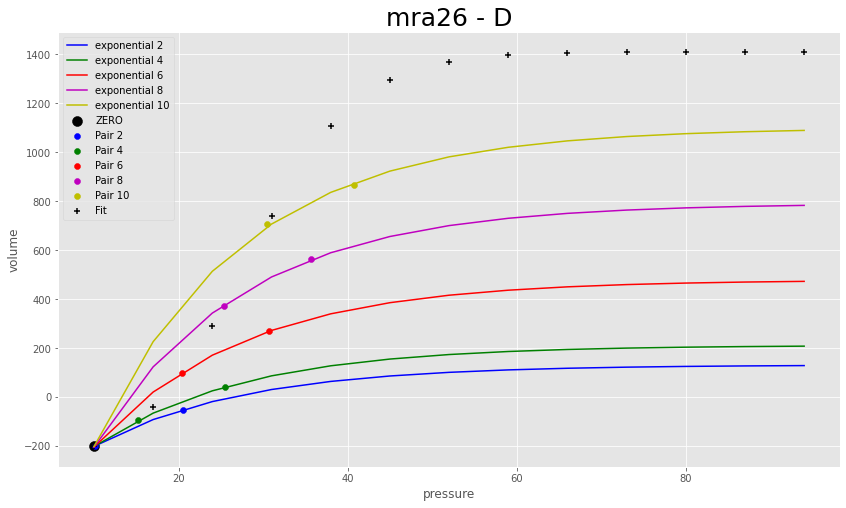

In [27]:
import matplotlib.pyplot as plt
plot_exponentials(best_fit, best_b, guess_zero, exponential_cicle_fixed_b)

In [65]:
df_test = df.query("manobra == 'D'")\
            .sort_values(by = "error")\
            .reset_index(drop=True)\
            .loc[:4]\
            .copy()

In [66]:
df_test[["best_b", "guess_zero"]] = df_test.apply(find_best_b, axis = 1, result_type="expand")

Best b: 0.05700000000000001
Best zero: [  10.05812538 -199.43215422]


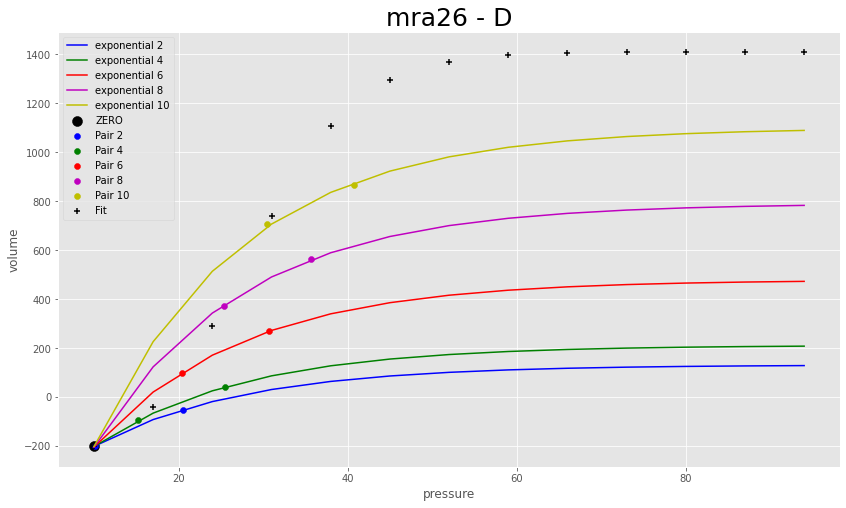

Best b: 0.05700000000000001
Best zero: [  10.05812538 -199.43215422]


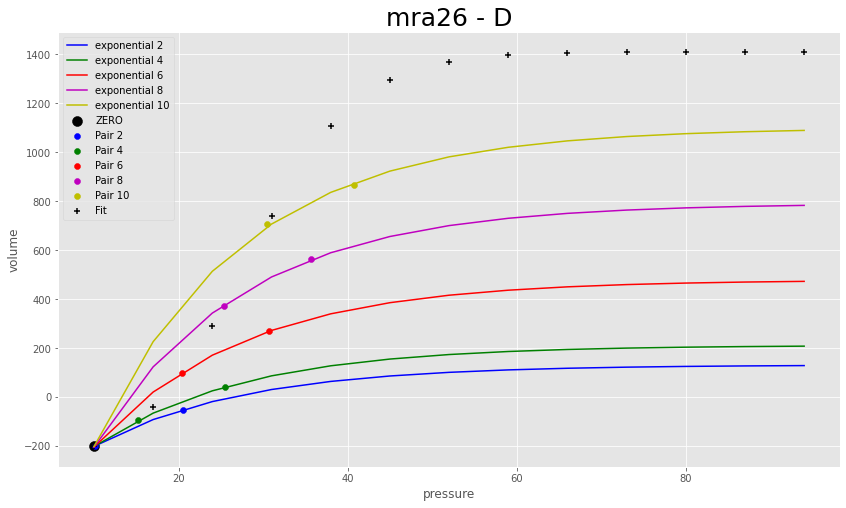

Best b: 0.12400000000000007
Best zero: [  9.82526083 -64.77392833]


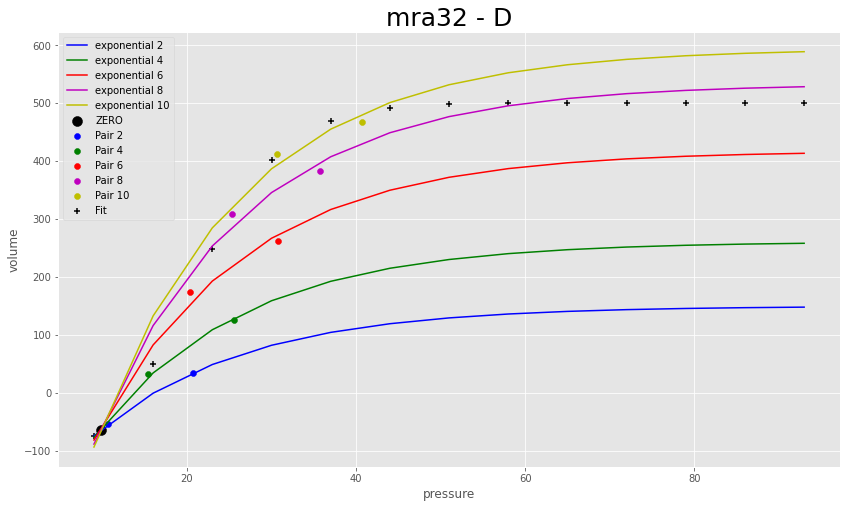

Best b: 0.12400000000000007
Best zero: [  9.82526083 -64.77392701]


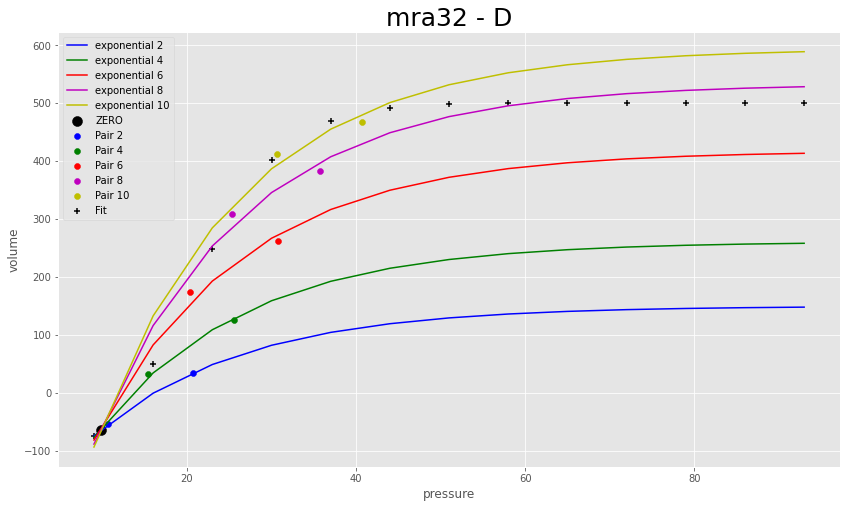

Best b: 0.12400000000000007
Best zero: [  9.82526083 -64.77392749]


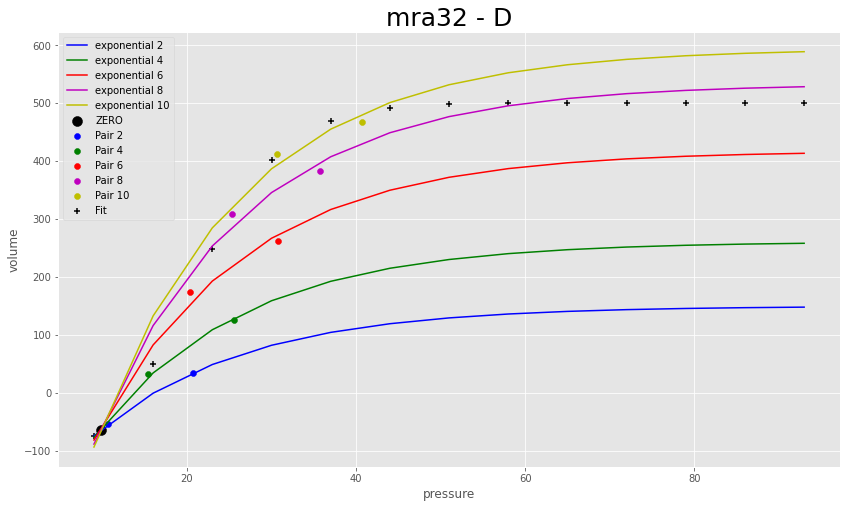

0    None
1    None
2    None
3    None
4    None
dtype: object

In [67]:
def myPlot(x):
    plot_exponentials(x, x.best_b, x.guess_zero, exponential_cicle_fixed_b)

df_test.apply(myPlot,axis=1)

In [40]:
def my_test(x):
    return find_best_b(x)
    
var = df_test.apply(my_test, axis=1)

Optimal parameters not found: Number of calls to function has reached maxfev = 800.
Optimal parameters not found: Number of calls to function has reached maxfev = 800.
Optimal parameters not found: Number of calls to function has reached maxfev = 800.
Optimal parameters not found: Number of calls to function has reached maxfev = 800.
Optimal parameters not found: Number of calls to function has reached maxfev = 800.
Optimal parameters not found: Number of calls to function has reached maxfev = 800.
Optimal parameters not found: Number of calls to function has reached maxfev = 800.
Optimal parameters not found: Number of calls to function has reached maxfev = 800.
Optimal parameters not found: Number of calls to function has reached maxfev = 800.
Optimal parameters not found: Number of calls to function has reached maxfev = 800.
Optimal parameters not found: Number of calls to function has reached maxfev = 800.
Optimal parameters not found: Number of calls to function has reached maxfev

ValueError: attempt to get argmin of an empty sequence

In [41]:
df_test

,subject,manobra,n_point,function,function_name,estimator,error,param,interp_point,interp_pressure,interp_volume,raw_data
0,mra26,D,5,<function sigmoid at 0x7fdeaaaed0d0>,sigmoid,dogbox,0.227276,"[-296.6860380701256, 1708.233716763266, 28.173...",5,"[10.178125381469727, 15.249219179153442, 20.32...","[-197.8517303466797, -93.77818494931996, 93.38...","[[10.178125381469727, -197.8517303466797], [20..."
1,mra26,D,5,<function sigmoid at 0x7fdeaaaed0d0>,sigmoid,lm,0.227276,"[-296.6860380729812, 1708.2337167840847, 28.17...",5,"[10.178125381469727, 15.249219179153442, 20.32...","[-197.8517303466797, -93.77818494931996, 93.38...","[[10.178125381469727, -197.8517303466797], [20..."
2,mra34,B,3,<function sigmoid at 0x7fdeaaaed0d0>,sigmoid,lm,0.924533,"[-1472.3912388355923, 5616.372991272574, 42.76...",5,"[10.135156631469727, 12.601953506469727, 15.06...","[-149.72845458984375, -56.23062894013785, 37.3...","[[10.135156631469727, -149.72845458984375], [2..."
3,mra34,B,3,<function sigmoid at 0x7fdeaaaed0d0>,sigmoid,trf,0.924549,"[-1472.5090130028595, 5617.355117277386, 42.77...",5,"[10.135156631469727, 12.601953506469727, 15.06...","[-149.72845458984375, -56.23062894013785, 37.3...","[[10.135156631469727, -149.72845458984375], [2..."
4,mra34,B,3,<function sigmoid at 0x7fdeaaaed0d0>,sigmoid,dogbox,0.924550,"[-1472.5483174283804, 5617.68399790547, 42.777...",5,"[10.135156631469727, 12.601953506469727, 15.06...","[-149.72845458984375, -56.23062894013785, 37.3...","[[10.135156631469727, -149.72845458984375], [2..."
5,mra29,B,3,<function sigmoid at 0x7fdeaaaed0d0>,sigmoid,trf,1.052172,"[2423.2194943969866, -3537.160236836546, 35.92...",5,"[10.26111125946045, 12.703298807144165, 15.145...","[-307.4459228515625, -231.4521733687988, -155....","[[10.26111125946045, -307.4459228515625], [20...."
6,mra33,B,3,<function sigmoid at 0x7fdeaaaed0d0>,sigmoid,lm,1.220250,"[-846.9066618177858, 3337.6055909982824, 25.76...",5,"[10.303646087646484, 12.747070550918579, 15.19...","[146.587890625, 244.9124420187244, 344.5037279...","[[10.303646087646484, 146.587890625], [20.1421..."
7,mra33,B,3,<function sigmoid at 0x7fdeaaaed0d0>,sigmoid,trf,1.220251,"[2490.718245682478, -3337.6307744565506, 25.76...",5,"[10.303646087646484, 12.747070550918579, 15.19...","[146.587890625, 244.9124420187244, 344.5037279...","[[10.303646087646484, 146.587890625], [20.1421..."
8,mra33,B,3,<function sigmoid at 0x7fdeaaaed0d0>,sigmoid,trf,1.465227,"[2207.2907406153017, -2943.2923835284914, 23.9...",10,"[10.303646087646484, 11.389612515767416, 12.47...","[146.587890625, 190.2876912444331, 233.9874918...","[[10.303646087646484, 146.587890625], [20.1421..."
9,mra34,B,3,<function sigmoid at 0x7fdeaaaed0d0>,sigmoid,lm,1.490014,"[-1474.2650755519403, 5609.384443647421, 42.68...",10,"[10.135156631469727, 11.231510798136393, 12.32...","[-149.72845458984375, -108.1738654121967, -66....","[[10.135156631469727, -149.72845458984375], [2..."


In [ ]:
plot_exponentials()